# Imports and Data Processing

In [1]:
%tensorflow_version 1.x
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import LSTM
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('/content/drive/My Drive/moral.csv')

In [4]:
data[' bias_count'] = (data[' bias_count'] > 0.07)
data[[" HarmVirtue", " HarmVice"," FairnessVirtue",
                 " FairnessVice", " IngroupVirtue",
                 " IngroupVice", " AuthorityVirtue",
                 " AuthorityVice", " PurityVirtue", " PurityVice", "Offensive",
      " MoralityGeneral_title"]] = data[[" HarmVirtue", " HarmVice"," FairnessVirtue",
                 " FairnessVice", " IngroupVirtue",
                 " IngroupVice", " AuthorityVirtue",
                 " AuthorityVice", " PurityVirtue", " PurityVice", "Offensive",
      " MoralityGeneral_title"]] > 0

data

,text,HarmVirtue,HarmVice,FairnessVirtue,FairnessVice,IngroupVirtue,IngroupVice,AuthorityVirtue,AuthorityVice,PurityVirtue,PurityVice,bias_count,Offensive,MoralityGeneral_title
0,"“This is madness,” Arnold Roth told the Algeme...",False,True,False,False,True,True,False,False,False,False,False,True,False
1,A victim of the anti-police shooting in Baton ...,True,True,False,False,True,False,True,True,False,False,True,True,False
2,Natural disasters like Hurricane Irma prompt p...,False,True,False,False,False,True,True,False,True,False,True,True,False
3,New York Times movie critic Andy Webster made ...,False,False,False,False,False,False,False,False,False,False,True,False,False
4,Former Department of Homeland Security (DHS) S...,True,True,False,False,True,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,It's the little things that matter in campaign...,False,False,False,False,True,False,False,False,False,False,False,False,False
2853,"Moments ago, against the backdrop of congress ...",True,True,False,False,True,True,True,False,False,True,True,True,False
2854,Earlier today President Trump joined with Labo...,False,False,False,False,True,False,True,False,False,False,True,False,False
2855,"President Donald Trump's ""fire and fury"" ultim...",False,False,False,False,False,True,False,False,False,False,False,False,False


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
def preprocess(text):
    text = text.lower()

    # Clean the text
    text = re.sub(r'http\S+','',text)

    text = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)

    text = re.sub(r"\+", " plus ", text)
    
    text = re.sub("\d+", " ", text)

    text = re.sub(r",", " ", text)

    text = re.sub(r"\.", " ", text)

    text = re.sub(r"!", " ", text)

    text = re.sub(r"\?", " ", text)

    text = re.sub(r"'", " ", text)

    text = re.sub(r":", " : ", text)

    text = re.sub(r"\s{2,}", " ", text)

    
    word_tokens = word_tokenize(text)

    filtered = [w for w in word_tokens if not w in stop_words] 

    text = ' '.join(filtered)

    return text

data.text = data.text.apply(preprocess)

In [0]:
X = []
sentences = list(data["text"])
for sen in sentences:
    X.append(sen)

categories = [" HarmVirtue", " HarmVice"," FairnessVirtue",
                 " FairnessVice", " IngroupVirtue",
                 " IngroupVice", " AuthorityVirtue",
                 " AuthorityVice", " PurityVirtue", 
                 " PurityVice", " bias_count", "Offensive"]

y =data[categories]

In [8]:
data['text'].str.split(' ').apply(len).describe()

count    2857.000000
mean      346.201610
std       256.563555
min        97.000000
25%       186.000000
50%       273.000000
75%       422.000000
max      2938.000000
Name: text, dtype: float64

In [9]:
from collections import Counter
result = Counter(" ".join(data['text'].values.tolist()).split(" ")).keys()
len(result)

41742

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=420) 

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

maxlen = 422

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Model Training and Evaluation

In [11]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200)(deep_inputs)
LSTM_Layer_1 = LSTM(1024, dropout =  0.5)(embedding_layer)
dense_layer_1 = Dense(12, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 422)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 422, 200)          7606800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024)              5017600   
_________________________________________________________________
dense_1 (Dense)              (None, 12)                12300     
Total params: 12,636,700
Trainable params: 12,636,700
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=2, validation_split=0.3)

Train on 1599 samples, validate on 686 samples
Epoch 1/20
 - 36s - loss: 0.5160 - acc: 0.7452 - val_loss: 0.5202 - val_acc: 0.7417
Epoch 2/20
 - 36s - loss: 0.5050 - acc: 0.7465 - val_loss: 0.5139 - val_acc: 0.7386
Epoch 3/20
 - 36s - loss: 0.5068 - acc: 0.7414 - val_loss: 0.5204 - val_acc: 0.7410
Epoch 4/20
 - 36s - loss: 0.5077 - acc: 0.7404 - val_loss: 0.5195 - val_acc: 0.7414
Epoch 5/20
 - 36s - loss: 0.5090 - acc: 0.7387 - val_loss: 0.5185 - val_acc: 0.7437
Epoch 6/20
 - 36s - loss: 0.5015 - acc: 0.7434 - val_loss: 0.5147 - val_acc: 0.7409
Epoch 7/20
 - 36s - loss: 0.5008 - acc: 0.7402 - val_loss: 0.5299 - val_acc: 0.7400
Epoch 8/20
 - 36s - loss: 0.5001 - acc: 0.7459 - val_loss: 0.5134 - val_acc: 0.7423
Epoch 9/20
 - 36s - loss: 0.4950 - acc: 0.7460 - val_loss: 0.5121 - val_acc: 0.7363
Epoch 10/20
 - 36s - loss: 0.4927 - acc: 0.7466 - val_loss: 0.5137 - val_acc: 0.7423
Epoch 11/20
 - 36s - loss: 0.4919 - acc: 0.7469 - val_loss: 0.5124 - val_acc: 0.7345
Epoch 12/20
 - 36s - loss: 

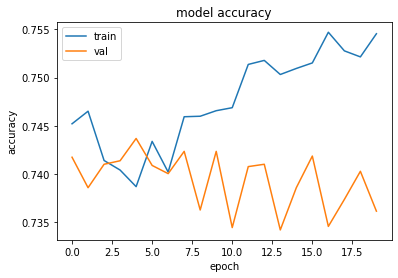

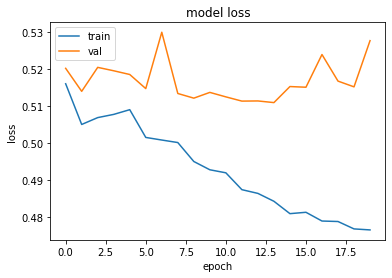

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
pred = model.predict(X_test) > 0.5

print('Overall Accuracy: ', model.evaluate(X_test, y_test)[1])

print('Accuracy Score per label:\n', np.round((pred == y_test).mean(), 2))

572/572 [==============================] - 7s 13ms/step
Overall Accuracy:  0.7341200709342957
Accuracy Score per label:
  HarmVirtue         0.54
 HarmVice           0.59
 FairnessVirtue     0.83
 FairnessVice       0.90
 IngroupVirtue      0.66
 IngroupVice        0.80
 AuthorityVirtue    0.72
 AuthorityVice      0.83
 PurityVirtue       0.90
 PurityVice         0.87
 bias_count         0.52
Offensive           0.65
dtype: float64


In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200)(deep_inputs)
LSTM_Layer_1 = LSTM(1024, dropout =  0.5)(embedding_layer)
dense_layer_1 = Dense(12, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [22]:
history = model.fit(X_train, y_train, batch_size=64, epochs=8, verbose=2)

Epoch 1/8
 - 46s - loss: 0.5390 - acc: 0.7321
Epoch 2/8
 - 46s - loss: 0.5101 - acc: 0.7435
Epoch 3/8
 - 46s - loss: 0.5081 - acc: 0.7403
Epoch 4/8
 - 46s - loss: 0.5014 - acc: 0.7447
Epoch 5/8
 - 46s - loss: 0.4955 - acc: 0.7446
Epoch 6/8
 - 46s - loss: 0.4900 - acc: 0.7480
Epoch 7/8
 - 46s - loss: 0.4906 - acc: 0.7472
Epoch 8/8
 - 46s - loss: 0.4883 - acc: 0.7445


In [23]:
pred = model.predict(X_test) > 0.5

print('Overall Accuracy: ', model.evaluate(X_test, y_test)[1])

print('Accuracy Score per label:\n', np.round((pred == y_test).mean(), 2))

572/572 [==============================] - 7s 12ms/step
Overall Accuracy:  0.738636314868927
Accuracy Score per label:
  HarmVirtue         0.53
 HarmVice           0.58
 FairnessVirtue     0.84
 FairnessVice       0.92
 IngroupVirtue      0.66
 IngroupVice        0.83
 AuthorityVirtue    0.72
 AuthorityVice      0.83
 PurityVirtue       0.90
 PurityVice         0.87
 bias_count         0.51
Offensive           0.66
dtype: float64


# Saving the Trained Network and Tokenizer for Later Use in Recommender System

In [0]:
#model.save_weights('deep.model')

In [0]:
import pickle

In [0]:
#pickle.dump(tokenizer, open('deep.tokenizer', 'wb'))

In [0]:
t = pickle.load(open('deep.tokenizer', 'rb'))

In [28]:
t.texts_to_sequences(['I am a boy and I love girls'])

[[13759, 2713, 3884, 515, 1126]]

In [29]:
tokenizer.texts_to_sequences(['I am a boy and I love girls'])

[[13759, 2713, 3884, 515, 1126]]

In [0]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200)(deep_inputs)
LSTM_Layer_1 = LSTM(1024, dropout =  0.5)(embedding_layer)
dense_layer_1 = Dense(12, activation='sigmoid')(LSTM_Layer_1)
model_loaded = Model(inputs=deep_inputs, outputs=dense_layer_1)

model_loaded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



In [0]:
model_loaded.load_weights('deep.model')

In [32]:
model_loaded.evaluate(X_test,y_test)

572/572 [==============================] - 8s 14ms/step


[0.5149457867328937, 0.738490641117096]

In [33]:
model.evaluate(X_test,y_test)

572/572 [==============================] - 7s 13ms/step


[0.5108070748669284, 0.738636314868927]